In [ ]:
# спонсор решения - попугай Кеша https://www.youtube.com/watch?v=mFNlzb1e0FM

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.model_selection import train_test_split

from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle

from sklearn.metrics import f1_score, roc_auc_score, precision_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [ ]:
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection6_materials/'
items = pd.read_csv(parent_path + 'items.csv')
purchases = pd.read_csv(parent_path + 'purchases.csv')

source = pd.merge(purchases, items.rename({'Name': 'item'}, axis=1))

# make dataset

In [ ]:
# маска покупок чая
tea_mask = source['item_type'] == 'чай'

# id покупателей чая
tea_drinkers = source.loc[tea_mask, 'user_id'].unique()

In [ ]:
# разметка: покупатели чая - класс 1, остальные - 0
target = 'tea_drinker'
train = source.copy()
train.loc[tea_mask, target] = 1
train.loc[~tea_mask, target] = 0
train[target] = train[target].astype(np.int8)

# преобразование категорий
# item_id_dict = dict(zip(items['Name'], map(str, range(items['Name'].size))))
# item_cat_dict = dict(zip(items['item_category'].unique(), map(str, range(items['item_category'].unique().size))))
# item_brand_dict = dict(zip(items['item_brand'].unique(), map(str, range(items['item_brand'].unique().size))))
# item_type_dict = dict(zip(items['item_type'].unique(), map(str, range(items['item_type'].unique().size))))

# train['item_id'] = train['item'].map(item_id_dict)
# train['item_category'] = train['item_category'].map(item_cat_dict)
# train['item_brand'] = train['item_brand'].map(item_brand_dict)
# train['item_type'] = train['item_type'].map(item_type_dict)

In [ ]:
train.sample(5)

,user_id,item,item_category,item_brand,item_weight,item_type,tea_drinker
96102,dc4a943f-83e7-51a7-bb6e-51c8a5c3440e,колбаса в/к велком сервелат кг,"Птица, мясо, деликатесы",велком,NaN,колбаса,0
3886,ccf331e8-8f66-51f0-8404-cfc1655ae674,шоколад lindt creation молочный пралине с вафл...,"Хлеб, сладости, снеки",lindt,0.15 кг,шоколад,0
97650,9daed2f4-1ab2-5eb1-a78b-89ac954e6b16,"колбаса ремит сервелат варено-копченая гост, 400г","Птица, мясо, деликатесы",ремит,0.4 кг,колбаса,0
52066,3c9b6f14-ed8e-5e40-b3ae-e11b4a5e2bba,кофе nescafe gold espresso растворимый 85 г,"Чай, кофе, сахар",nescafe,85 г,кофе,0
11584,f8b840d9-e342-5191-bffc-5fcf29da5e20,корм для золотых рыбок tetra goldfish colour s...,Зоотовары,tetra,0.11 кг,корм,0


In [ ]:
# группировка по user_id, формирования last_purchases
agg_dict = {'item': list,
            # 'item_id': list,
            # 'item_category': list,
            # 'item_brand': list,
            # 'item_type': list,
            target: max}
data = train.groupby('user_id').agg(agg_dict).reset_index().rename({'item': 'last_purchases'}, axis=1)
data['last_purchases'] = data['last_purchases'].apply(lambda x: ' '.join(x))

# очистка last_purchases от мусора (объемы и развесовка)
data['last_purchases'] = data['last_purchases'].str.replace(r'\s?(\d+|\b(г|мл)\b)\S*', '', regex=True)

In [ ]:
data.head(3)

,user_id,last_purchases,tea_drinker
0,00002f01-66e4-5ab8-8d1a-1562a4ddd418,зубная паста splat stress off антистресс зубна...,0
1,0000fed8-b063-51ef-8ca4-c42c5bd022ad,шоколад schogetten black & white молочный с ку...,0
2,0004cfe8-bcb2-5a2c-904b-643e0469cbe3,шоколад воздушный темный сыр белебеевский башк...,0


# featuring

In [ ]:
class TfIdfFeature(BaseEstimator, TransformerMixin):
  def __init__(self, on, **kwargs):
    self.on = on
    self.kwargs = kwargs
  
  def fit(self, X, y=None):
    self.vec = TfidfVectorizer(**self.kwargs)
    self.vec.fit(X[self.on])
    return self
  
  def transform(self, X):
    df = X.copy()
    csr = self.vec.transform(X[self.on])
    sparse.hstack([sparse.csr_matrix(df.drop(self.on, axis=1)), csr])
    return csr

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):
  def __init__(self, drop=[], leave=[]):
    self.drop = drop
    self.leave = leave

  def fit(self, X, y=None):
    self.leave = list(set(self.leave) & set(X.columns))
    self.drop = list(set(self.drop) & set(X.columns))
    return self

  def transform(self, X):
    if self.leave:
      return X[self.leave]
    elif self.drop:
      return X.drop(columns=self.drop)
    else:
      return X

# modeling

### manual

In [ ]:
# попытка в биграммы
prepare_pipeline = Pipeline([('drop', DropColumns(leave=['last_purchases'])),
                             ('tf-idf', TfIdfFeature(on='last_purchases', ngram_range=(2, 2))),
                             ('sgd', SGDClassifier(random_state=17,
                                                   max_iter=150,
                                                   penalty='l1',
                                                   loss='modified_huber',
                                                   alpha=1e-5,
                                                   learning_rate='adaptive',
                                                   eta0=0.25,
                                                   early_stopping=True,
                                                  #  class_weight='balanced'
                                                   )),
                             ])

In [ ]:
# вариант на топе очищенных слов товарных позиций
# prepare_pipeline = Pipeline([('drop', DropColumns(leave=['last_purchases'])),
#                              ('tf-idf', TfIdfFeature(on='last_purchases')),
#                              ('sgd', SGDClassifier(random_state=17,
#                                                    max_iter=100,
#                                                    loss='modified_huber',
#                                                    learning_rate='adaptive',
#                                                    eta0=0.1,
#                                                    early_stopping=True,
#                                                   #  class_weight='balanced'
#                                                    )),
#                              ])

Best Threshold=0.276, F-Score=0.997, Precision=1.000, Recall=0.994


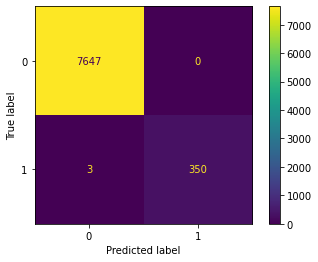

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(target, axis=1), data[target], random_state=0)

prepare_pipeline.fit(X_train, y_train)
preds = prepare_pipeline.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_valid, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

preds = preds > thresholds[ix]
ConfusionMatrixDisplay.from_predictions(y_valid, preds);

In [ ]:
feature_names = [i for i in prepare_pipeline.named_steps["tf-idf"].vec.get_feature_names_out()]
feature_weights = [i for i in prepare_pipeline.named_steps["sgd"].coef_[0]]
weights = pd.DataFrame({'feature_name': feature_names,
              'feature_weight': feature_weights}).sort_values('feature_weight', ascending=False)
#топ 100 слов
weights['feature_name'].iloc[:100].values

array(['чай черный', 'чай greenfield', 'чай lipton', 'чай fuzetea',
       'чай tess', 'чай зеленый', 'чай майский', 'чай curtis',
       'чай milford', 'черный байховый', 'чай richard', 'чай dammann',
       'чай newby', 'месяцев чай', 'чай ahmad', 'ahmad tea',
       'чай азерчай', 'чай mlesna', 'зернах чай', 'чай hyleys',
       'чай витацентр', 'черный листовой', 'молотый чай', 'чай twinings',
       'чай принцесса', 'чай maitre', 'чай бабушкино', 'кг чай',
       'чай nadin', 'чай basilur', 'волос чай', 'earl grey', 'чай nestea',
       'ст чай', 'пэт чай', 'чай kwinst', 'молочный чай',
       'черный крупнолистовой', 'сублимированный чай', 'растворимый чай',
       'тянь жень', 'чай травяной', 'чай sonnentor', 'принцесса нури',
       'richard royal', 'чай akbar', 'чай vитамин', 'иван чай',
       'чай fleur', 'эрл грей', 'чай heladiv', 'чай айдиго',
       'холодный зеленый', 'чай лисма', 'принцесса ява', 'шт чай',
       'пакет чай', 'чай hipp', 'черный дракон', 'newby черный',

### P / U bootstrap recursive

In [ ]:
def bootstrap_fit(X, y, *, fracs, passes, replace=False, ext_val=True, update_method='stack', random_seed=None):
  """ Рекурсивное обучение классификатора на бутстрапированных выборках
  fracs: float or tuple(float, float) - доля обучающей выборки от общей. Если tuple, то fracs[0] - доля Positives, fracs[1] - доля Unlabeled
  passes: int - кол-во итераций обучения
  replace: bool ir tuple(bool, bool) - разрешить дубли объектов в обучающей выборке. Если tuple, то replace[0] - для Positives, replace[1] - для Unlabeled
  ext_val: extended validation, if True добавляет неиспользуемые в обучении данные в валидацию
  update_method: на каждой итерации обновлять метки классов предсказаниями обученной модели указанным способом 
                  (None - не обновлять, replace - целиком по предсказаниям, stack - добавить предсказания Positives к истинным Positive-меткам)
  """
  metrics = []
  rng = np.random.default_rng(random_seed)      # init randomizer
  tea_drinkers = y == 1        # target mask
  # get fracs
  if isinstance(fracs, float):
    p_frac = u_frac = fracs
  else:
    p_frac = fracs[0]
    u_frac = fracs[1]
  # get replace
  if isinstance(fracs, bool):
    p_replace = u_replace = replace
  else:
    p_replace = replace[0]
    u_replace = replace[1]

  # get train data bootstraps
  P_index = rng.choice(X[tea_drinkers].index, size=int(X[tea_drinkers].shape[0] * p_frac), replace=p_replace)     # покупатели чая, участвующие в обучении
  U_index = rng.choice(X[~tea_drinkers].index, size=int(X[~tea_drinkers].shape[0] * u_frac), replace=u_replace)   # потенциальные покупатели чая, участвующие в обучении
  # concat P and U to one dataset and shuffle, do the same with target
  rs = rng.integers(1000) if random_seed else None
  train = shuffle(pd.concat([X.loc[P_index], X.loc[U_index]], axis=0), random_state=rs)
  target = shuffle(pd.concat([y.loc[P_index], y.loc[U_index]], axis=0), random_state=rs)
  
  # train/valid split
  rs = rng.integers(1000) if random_seed else None
  X_train, X_valid, y_train, y_valid = train_test_split(train, target, random_state=rs)
  # add unused data to validation
  if ext_val:
    rs = rng.integers(1000) if random_seed else None
    left_P_index = ~X.index.isin(P_index)
    left_U_index = ~X.index.isin(U_index)
    X_valid = shuffle(pd.concat([X_valid, X[left_P_index & left_U_index]], axis=0), random_state=rs)
    y_valid = shuffle(pd.concat([y_valid, y[left_P_index & left_U_index]], axis=0), random_state=rs)

  # fit model
  prepare_pipeline.fit(X_train, y_train)
  pred_proba = prepare_pipeline.predict_proba(X_valid)[:, 1]

  # calc metrics
  precision, recall, thresholds = precision_recall_curve(y_valid, pred_proba)
  fscore = (2 * precision * recall) / (precision + recall)
  ix = fscore.argmax()
  metrics.append([thresholds[ix], precision[ix], recall[ix], fscore[ix]])

  # recursive call
  if passes - 1 > 0:
    rs = rng.integers(1000) if random_seed else None
    if update_method == 'replace':
      y_upd = pd.Series(prepare_pipeline.predict(X))
    elif update_method == 'stack':
      preds = prepare_pipeline.predict(X)
      upd_index = (preds == 1) | tea_drinkers
      y_upd = y.copy()
      y_upd[upd_index] = 1
      y_upd[~upd_index] = 0
    else:
      y_upd = y
    step_metric = bootstrap_fit(X, y_upd, fracs=fracs, passes=passes - 1, replace=replace, ext_val=ext_val, update_method=update_method, random_seed=rs)
    metrics.extend(step_metric)

  return metrics

# metrics

### funcs

In [ ]:
def show(metrics, index=None):
  index = [f'step {n + 1}' for n in range(len(metrics))] if index is None else index
  return pd.DataFrame(metrics, index=index, columns=['thresholds', 'precision', 'recall', 'f1-score'])

In [ ]:
def plot_metrics(metrics):  
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle('Умненькое название красивых картиночек')
  ax[0].set_title('precision')
  ax[0].plot(fracs, np.array(metrics)[:, 1], color='orange', label='natural')
  ax[0].plot(fracs, metric_lin_approx(fracs, np.array(metrics)[:, 1]), color='darkred', label='trendline')
  ax[0].legend()

  ax[1].set_title('recall')
  ax[1].plot(fracs, np.array(metrics)[:, 2], color='green', label='natural')
  ax[1].plot(fracs, metric_lin_approx(fracs, np.array(metrics)[:, 2]), color='darkred', label='trendline')
  ax[1].legend()

  ax[2].set_title('f-score')
  ax[2].plot(fracs, np.array(metrics)[:, 3], color='purple', label='natural')
  ax[2].plot(fracs, metric_lin_approx(fracs, np.array(metrics)[:, 3]), color='darkred', label='trendline')
  ax[2].legend()

  plt.show()

In [ ]:
def metric_lin_approx(fracs, metrics):
  sgd_reg = SGDRegressor(learning_rate='adaptive', eta0=0.4, random_state=17)
  sgd_reg.fit(fracs.reshape(-1, 1), metrics)
  return sgd_reg.predict(fracs.reshape(-1, 1))

### out

In [ ]:
%%time
# динамика финальных метрик при снижении доли positive-обучающей выборки
# остальные параметры варьируются по настроению

start = 0.1
points = 25

metrics = []
fracs = np.linspace(start, 1, points)
for frac in fracs:
  metrics.append(bootstrap_fit(data.drop(target, axis=1), data[target],
                               passes=3,
                               fracs=[frac, 1], replace=[True, False],
                               random_seed=59)[-1])

CPU times: user 5min 14s, sys: 8.33 s, total: 5min 22s
Wall time: 5min 15s


In [ ]:
show(metrics, index=fracs)

,thresholds,precision,recall,f1-score
0.1000,0.058295,0.979381,0.896932,0.936345
0.1375,0.084318,0.991349,0.932465,0.961006
0.1750,0.087820,0.989655,0.955075,0.972058
0.2125,0.088291,0.988160,0.929734,0.958057
0.2500,0.077737,0.982898,0.962115,0.972395
0.2875,0.104224,0.994480,0.965179,0.979610
0.3250,0.107167,0.996310,0.983607,0.989918
0.3625,0.131304,0.996223,0.979573,0.987828
0.4000,0.113546,0.997079,0.980843,0.988894
0.4375,0.115185,0.991379,0.984776,0.988067


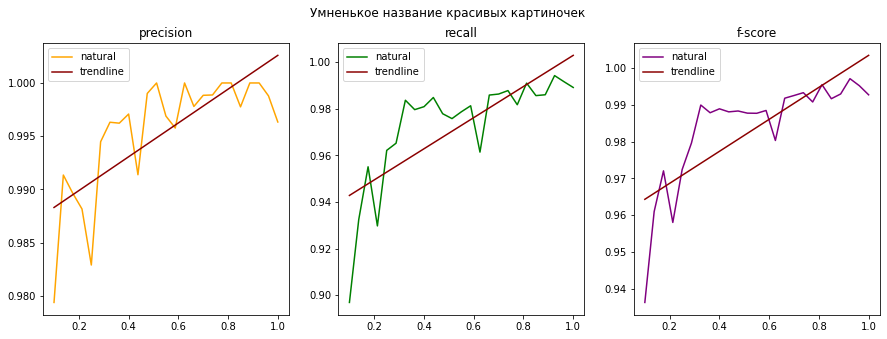

In [ ]:
plot_metrics(metrics)

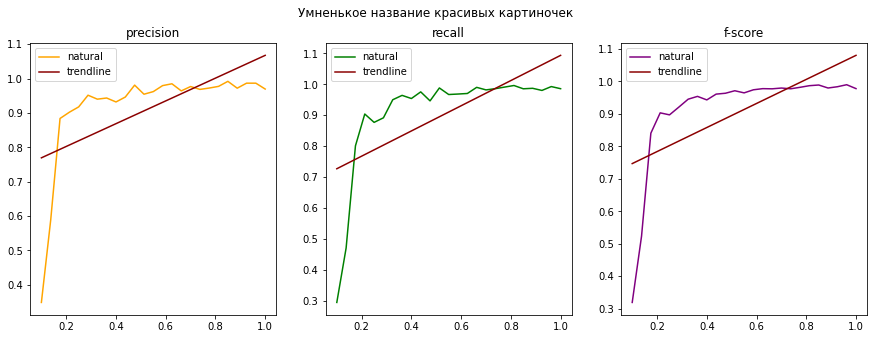

In [ ]:
metrics = []
fracs = np.linspace(start, 1, points)
for frac in fracs:
  metrics.append(bootstrap_fit(data.drop(target, axis=1), data[target],
                               passes=3,
                               fracs=[frac, 1], replace=[True, False],
                               update_method='replace',
                               random_seed=61)[-1])
plot_metrics(metrics)

При полном обновлении меток на каждой итерации результат в данной задаче получается стабильнее

In [ ]:
# ы
metrics = bootstrap_fit(data.drop(target, axis=1), data[target],
                        passes=9,
                        fracs=[0.9, 1], replace=[True, False],
                        update_method='replace',
                        random_seed=59)

show(metrics)

,thresholds,precision,recall,f1-score
step 1,0.183975,0.998843,0.986286,0.992524
step 2,0.164990,0.982630,0.988764,0.985688
step 3,0.279539,0.980080,0.976190,0.978131
step 4,0.242959,0.971233,0.987465,0.979282
step 5,0.180148,0.967977,0.991058,0.979381
step 6,0.407296,0.989426,0.989426,0.989426
step 7,0.372952,0.989231,0.981679,0.985441
step 8,0.284111,0.985507,0.990291,0.987893
step 9,0.346256,0.991625,0.993289,0.992456


для Unlabled лучше оставлять `fracs=1`, `replace=False`.

для Positive при уменьшении `frac` уменьшается качество обучения (возможно из-за слишком маленькой обучающей выборки с positive-меткой)